In [1]:
import jax
import jax.numpy as jnp
import flax.linen as nn
import optax

import numpy as np

import tensorflow_probability.substrates.jax as tfp

import matplotlib.pyplot as plt

In [2]:
def fill_diagonal(a, val):
  assert a.ndim >= 2
  i, j = jnp.diag_indices(min(a.shape[-2:]))
  return a.at[..., i, j].set(val)

In [4]:
from typing import Sequence, Any
Array = Any

import numpy as np
import jax
import jax.numpy as jnp
import flax.linen as nn


class MLP(nn.Module):
  features: Sequence[int]

  @nn.compact
  def __call__(self, x):
    for feat in self.features[:-1]:
      x = nn.elu(nn.Dense(feat)(x))
    x = nn.Dense(self.features[-1])(x)
    return x

In [5]:
class Fishnet(nn.Module):
    theta_fid: jnp.array
    n_hidden_score: list
    n_hidden_fisher: list
    n_inputs: int=1
    n_parameters: int=2
    is_iid: bool=True
    priorCinv: jnp.array = jnp.eye(2)
    priormu: jnp.array = jnp.zeros((2,))

    def setup(self):

        self.model_score = MLP(self.n_hidden_score + (self.n_parameters,))
        self.model_fisher = MLP(self.n_hidden_fisher + (int(self.n_parameters * (self.n_parameters + 1)) // 2,))

    def __call__(self, x):
        
        if self.is_iid:
            score = self.model_score(x)
            fisher_cholesky = self.model_fisher(x)

            F = jax.vmap(self.construct_fisher_matrix_multiple)(fisher_cholesky)

            t = jnp.sum(score, axis=0) - jnp.einsum('ij,j->i', self.priorCinv, (self.theta_fid - self.priormu))
            F = jnp.sum(F, axis=0) + self.priorCinv
            #print("F", F.shape)
            mle = self.theta_fid + jnp.einsum('ijk,ik->ij', jnp.linalg.inv(F), t)

        else:
            score = self.model_score(jnp.squeeze(x))
            fisher_cholesky = self.model_fisher(jnp.squeeze(x))
            F = (self.construct_fisher_matrix_single)(fisher_cholesky)
            mle = self.theta_fid + jnp.einsum('jk,k->j', jnp.linalg.inv(F), score)

        # compute MLE
        
        return mle, score, F
    

    def construct_fisher_matrix_multiple(self, outputs):
        Q = jnp.squeeze(tfp.math.fill_triangular(outputs))
        # vmap the jnp.diag function for the batch
        _diag = jax.vmap(jnp.diag)
        middle = _diag(jnp.triu(Q) - nn.softplus(jnp.triu(Q)))
        padding = jnp.zeros(Q.shape)

        L = Q - fill_diagonal(padding, middle)

        return jnp.einsum('...ij,...jk->...ik', L, jnp.transpose(L, (0, 2, 1)))
    
    def construct_fisher_matrix_single(self, outputs):
        Q = tfp.math.fill_triangular(outputs)
        middle = jnp.diag(jnp.triu(Q) - nn.softplus(jnp.triu(Q)))
        padding = jnp.zeros(Q.shape)

        L = Q - fill_diagonal(padding, middle)

        return jnp.einsum('...ij,...jk->...ik', L, jnp.transpose(L, (1, 0)))


In [6]:
key = jax.random.PRNGKey(0)

model_single = Fishnet(jnp.zeros(2,), 
                n_hidden_fisher=[128,128], 
                n_hidden_score=[128,128],
                n_inputs=1,
                n_parameters=2,
                is_iid=False)

params = model_single.init(key, jax.random.normal(key, (10,)))

mle, score, F = model_single.apply(params, jax.random.normal(key, (10,)))

In [83]:
class FishnetDeepset(nn.Module):
    theta_fid: jnp.array
    n_hidden_score: list
    n_hidden_fisher: list
    n_hidden_globals: list
    n_inputs: int=1
    n_parameters: int=2
    is_iid: bool=True
    #priorCinv: jnp.array = jnp.eye(2)
    #priormu: jnp.array = jnp.zeros((2,))

    def setup(self):
        
        self.priorCinv = jnp.eye(self.n_parameters)
        self.priormu = jnp.zeros(self.n_parameters)

        self.model_score = MLP(self.n_hidden_score)
        self.model_fisher = MLP(self.n_hidden_fisher)
        self.model_globals = MLP(self.n_hidden_globals + (int(self.n_parameters \
                                        + int(self.n_parameters * (self.n_parameters + 1)) // 2),)
                                            )


    def __call__(self, x):
        
        score = self.model_score(x) #[:, jnp.newaxis]
        fisher_cholesky = self.model_fisher(x) #[:, jnp.newaxis]

        #print(score.shape)

        t = jnp.mean(score, axis=0)#- jnp.einsum('ij,j->i', self.priorCinv, (self.theta_fid - self.priormu))
        fisher_cholesky = jnp.mean(fisher_cholesky, axis=0)

        #print("t", t.shape)
        #print("fisher", fisher_cholesky.shape)

        outputs = self.model_globals(jnp.concatenate([t, fisher_cholesky], axis=-1))
        
        
        t = outputs[:self.n_parameters]
        fisher_cholesky = outputs[self.n_parameters:]

        #
        # print("fisher cholesky", fisher_cholesky.shape)

        F = self.construct_fisher_matrix_single((fisher_cholesky)) + self.priorCinv
        # #+ self.priorCinv

        mle = t
        #mle = jnp.einsum('jk,k->j', jnp.linalg.inv(F), t)

        return mle, score, F
    

    def construct_fisher_matrix_multiple(self, outputs):
        Q = jnp.squeeze(tfp.math.fill_triangular(outputs))
        # vmap the jnp.diag function for the batch
        _diag = jax.vmap(jnp.diag)
        middle = _diag(jnp.triu(Q) - nn.softplus(jnp.triu(Q)))
        padding = jnp.zeros(Q.shape)

        L = Q - fill_diagonal(padding, middle)

        return jnp.einsum('...ij,...jk->...ik', L, jnp.transpose(L, (0, 2, 1)))
    
    def construct_fisher_matrix_single(self, outputs):
        Q = tfp.math.fill_triangular(outputs)
        middle = jnp.diag(jnp.triu(Q) - nn.softplus(jnp.triu(Q)))
        padding = jnp.zeros(Q.shape)

        L = Q - fill_diagonal(padding, middle)

        return jnp.einsum('...ij,...jk->...ik', L, jnp.transpose(L, (1, 0)))


In [84]:
key = jax.random.PRNGKey(0)

model = FishnetDeepset(jnp.ones(2,), 
                n_hidden_fisher=[128,128], 
                n_hidden_score=[128,128],
                n_hidden_globals=[50,50],
                n_inputs=1,
                n_parameters=2,
                is_iid=True)

params = model.init(key, jnp.ones((10,1)))

mle, score, F = model.apply(params, jnp.ones((10,1)))

In [85]:
F.shape

(2, 2)

# do a regression scheme
load in Viraj's data and standardize for the network. we'll pad the input sets with zeros, up to $N_{\rm halo}=120$. Parameter combinations that result in fewer halos for the population will be automatically downweighted in the inference

In [109]:
import pickle
from astropy.table import Table
from astropy.cosmology import Planck15

# read in the pickle which contains a list of dictionaries 
with open('lucas_variations_fixed.pkl','rb') as f:
    dat = pickle.load(f)

In [110]:
data_ = np.zeros((len(dat), 120, 3))

theta_ = np.zeros((len(dat), 7))
for i,d in enumerate(dat):
    num_halos = d["z0_Mvir"].shape[0]
    data_[i, :num_halos, 0] = d["z0_Mstar"] / d["z0_Mvir"]
    data_[i, :num_halos, 1] = np.log10(d["z0_Mstar"])
    data_[i, :num_halos, 2] = np.log10(d["z0_Mvir"])
    
    theta_[i, :] = np.stack([d['etaM_A'],
                             d['etaM_alpha0'],
                             d['tdep_A'],
                             d['tdep_alpha0'],
                             d['tdep_beta'],
                             d['etaE_A'],
                             d['etaE_alpha0']])

(array([[1573.,  246.,  334., ...,    0.,    0.,    0.],
        [1224.,  302.,  291., ...,    0.,    0.,    0.],
        [1825.,  316.,   25., ...,    0.,    0.,    0.],
        ...,
        [1643.,  118.,  107., ...,    0.,    0.,    0.],
        [1650.,  103.,   79., ...,    0.,    0.,    0.],
        [1717.,   66.,   98., ...,    0.,    0.,    0.]]),
 array([0.        , 0.02105746, 0.04211492, 0.06317237, 0.08422983,
        0.10528729, 0.12634475, 0.1474022 , 0.16845966, 0.18951712,
        0.21057458]),
 <a list of 120 BarContainer objects>)

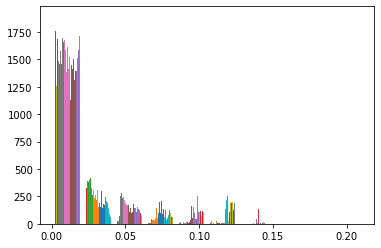

In [111]:
plt.hist(data_[..., 0])

In [112]:
theta_.shape

(2187, 7)

In [113]:
from sklearn.preprocessing import MinMaxScaler
scaler = MinMaxScaler(feature_range=(0.1, 1.0))

theta_ = scaler.fit_transform(theta_)

In [114]:
theta_.shape

(2187, 7)

In [115]:
# train the network for iid data
key = jax.random.PRNGKey(0)

model = FishnetDeepset(jnp.ones(7,), 
                n_hidden_fisher=[128,128], 
                n_hidden_score=[128,128],
                n_hidden_globals=[50,50],
                n_inputs=3,
                n_parameters=7)

w = model.init(key, jnp.ones((120,3)))

mle, score, F = model.apply(w, jnp.ones((120,3)))

In [116]:
mle

Array([-0.5387428 ,  0.21363637, -0.645092  ,  0.91910166, -0.0207474 ,
       -0.28191754, -0.50598454], dtype=float32)

In [117]:
np.linalg.det(F)

84.05179

In [118]:
data_ = jnp.array(data_)
theta_ = jnp.array(theta_)

In [119]:
batch_size = 27

data_ = data_.reshape(-1, batch_size, 120, 3)
theta_ = theta_.reshape(-1, batch_size, 7)

In [120]:
@jax.jit
def kl_loss(w, x_batched, theta_batched):

    def fn(x, theta):
       mle,score,F = model.apply(w, x)
       return mle, F
    
    mle, F = jax.vmap(fn)(x_batched, theta_batched)

    return -jnp.mean(-0.5 * jnp.einsum('ij,ij->i', (theta_batched - mle), \
                                             jnp.einsum('ijk,ik->ij', F, (theta_batched - mle))) \
                                                  + 0.5*jnp.log(jnp.linalg.det(F)), axis=0)

In [121]:
kl_loss(w, data_[10], theta_[10])

Array(45.801704, dtype=float32)

In [122]:
from tqdm import tqdm
import optax
tx = optax.adam(learning_rate=1e-4)
opt_state = tx.init(w)
loss_grad_fn = jax.value_and_grad(kl_loss)


batch_size = 27
epochs = 100


In [123]:
def body_fun(i, inputs):
    w,loss_val, opt_state = inputs
    x_samples = _data[i]
    y_samples = _theta[i]

    loss_val, grads = loss_grad_fn(w, x_samples, y_samples)
    updates, opt_state = tx.update(grads, opt_state)
    w = optax.apply_updates(w, updates)
    
    return w, loss_val, opt_state

In [151]:
key = jax.random.PRNGKey(999)

losses = jnp.zeros(epochs)

loss_val = 0.

n_train = 2187

lower = 0
upper = n_train // batch_size

pbar = tqdm(range(epochs), leave=True, position=0)

for j in pbar:
      key,rng = jax.random.split(key)

      # shuffle data every epoch
      randidx = jax.random.shuffle(key, jnp.arange(theta_.reshape(-1, 7).shape[0]))
      _data = data_.reshape(-1, 120, 3)[randidx].reshape(batch_size, -1, 120, 3)
      _theta = theta_.reshape(-1, 7)[randidx].reshape(batch_size, -1, 7)

      inits = (w, loss_val, opt_state)

      w, loss_val, opt_state = jax.lax.fori_loop(lower, upper, body_fun, inits)

      losses = losses.at[j].set(loss_val)
      #val_losses.append(val_loss)
      pbar.set_description('epoch %d loss: %.5f'%(j, loss_val))

epoch 99 loss: -7.03036: 100%|██████████| 100/100 [04:03<00:00,  2.44s/it]


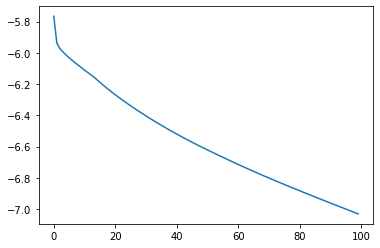

In [154]:
plt.plot(losses)

In [139]:
data_.shape

(81, 27, 120, 3)

In [155]:
_app = lambda d: model.apply(w, d)

mle_pred,_,F_pred = jax.vmap(_app)(data_.reshape(-1, 120, 3)[:])

(array([ 57.,  78., 278., 411., 625., 190., 174., 152., 162.,  60.]),
 array([-0.7795315 , -0.6122401 , -0.44494867, -0.27765724, -0.11036585,
         0.05692557,  0.22421697,  0.39150837,  0.5587998 ,  0.7260912 ,
         0.8933826 ], dtype=float32),
 <BarContainer object of 10 artists>)

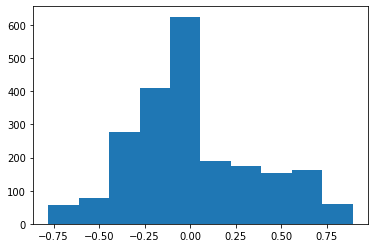

In [156]:
plt.hist((theta_.reshape(-1, 7) - mle_pred)[:, 2])

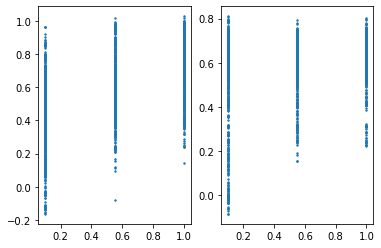

In [157]:
plt.subplot(121)
plt.scatter(theta_.reshape(-1,7)[:, 3], mle_pred[:, 3], s=2)
plt.subplot(122)
plt.scatter(theta_.reshape(-1,7)[:, 1], mle_pred[:, 1], s=2)

In [152]:
num_sims = 5000 # arbitrary
num_halos_per_sim = 120 # fixed

theta0 = np.random.uniform(low=0, high=23, size=(num_sims,))
theta1 = np.random.uniform(low=0, high=23, size=(num_sims,))

theta_total = np.stack([theta0, theta1,], -1) # should be shape (num_sims, 7)

In [153]:
theta_total.shape

(5000, 2)

In [152]:
@jax.jit
def Fisher(θ, n_d=n_d):
    Σ = θ[1]
    return jnp.array([[n_d / Σ, 0.], [0., n_d / (2. * Σ**2.)]])

F_true = jax.vmap(Fisher)(theta_.reshape(-1, 2)[-1000:])

In [153]:
F_true[:5]

Array([[[112.028824,   0.      ],
        [  0.      ,  62.75229 ]],

       [[192.69997 ,   0.      ],
        [  0.      , 185.66637 ]],

       [[ 50.472633,   0.      ],
        [  0.      ,  12.737433]],

       [[ 91.64879 ,   0.      ],
        [  0.      ,  41.9975  ]],

       [[ 46.800247,   0.      ],
        [  0.      ,  10.951315]]], dtype=float32)

In [154]:
F_pred[:5]

Array([[[129.65286   ,  -1.5524082 ],
        [ -1.5524082 ,  38.539387  ]],

       [[176.33308   ,  -0.83014643],
        [ -0.83014643, 130.63501   ]],

       [[ 41.35161   ,   0.44327524],
        [  0.44327524,  12.2382    ]],

       [[ 76.86422   ,   0.66495377],
        [  0.66495377,  30.64038   ]],

       [[ 46.99787   ,  -1.1218075 ],
        [ -1.1218075 ,  18.543173  ]]], dtype=float32)

In [155]:
θ_fid = jnp.array([0.0, 1.25])

lo = [-1.0, 0.5]
hi = [1.0, 3.0]

num = 10

xs = jnp.linspace(-1.0, 1.0, num) # MEAN
ys = jnp.linspace(0.5, 3.0, num) #jnp.logspace(-1.0, 0.0, num) # VARIANCE


xs,ys = jnp.meshgrid(xs, ys)

fishers = []

for _mu,_sigma in zip(xs.ravel(), ys.ravel()):
  fishers.append(Fisher(jnp.array([_mu,_sigma]), n_d=n_d))

No artists with labels found to put in legend.  Note that artists whose label start with an underscore are ignored when legend() is called with no argument.


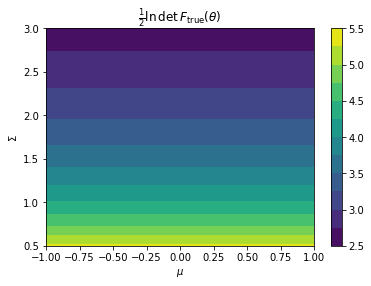

In [156]:
_data = jax.vmap(jnp.linalg.det)(jnp.array(fishers)).reshape(xs.shape) #/ ys #jnp.array(fishers)[:, 0, 0].reshape(xs.shape) / ys #jax.vmap(jnp.linalg.det)(jnp.array(fishers)).reshape(xs.shape)

im = plt.contourf(xs, ys, 0.5*np.log(_data), cmap='viridis', levels=10)
cbar = plt.colorbar(im)
#plt.yscale('log')
plt.ylabel('$\Sigma$')
plt.xlabel('$\mu$')
plt.title(r'$ \frac{1}{2} \ln \det F_{\rm true}(\theta)$')
plt.legend(framealpha=0., loc='lower left')
plt.show()

In [157]:
fishers_pred = []

key = jr.PRNGKey(99)
n_d_test = 500

def _getf(d):
    return model.apply(w, d)[2]


for mu,sigma in tqdm(zip(xs.ravel(), ys.ravel())):
  # generate many data realization at each gridpoint
    key, rng = jr.split(key)
    keys = jr.split(key, 2000)

    sims = jax.vmap(simulator)(keys, jnp.tile(jnp.array([[mu], [sigma]]), 2000).T)[:, :, jnp.newaxis]
    
    fpreds = jax.vmap(_getf)(sims)

    fishers_pred.append(jnp.mean(fpreds, axis=0))

100it [00:27,  3.62it/s]


In [158]:
jnp.linalg.det(fishers[30])


Array(2109.3748, dtype=float32)

In [159]:
jnp.linalg.det(fishers_pred[30])

Array(1923.811, dtype=float32)

No artists with labels found to put in legend.  Note that artists whose label start with an underscore are ignored when legend() is called with no argument.


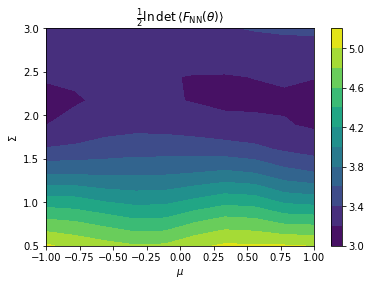

In [160]:
_data = jax.vmap(jnp.linalg.det)(jnp.array(fishers_pred)).reshape(xs.shape) #/ ys#jnp.array(fishers_pred)[:, 1, 1].reshape(xs.shape) / ys#jax.vmap(jnp.linalg.det)(jnp.array(fishers_pred)).reshape(xs.shape)

im = plt.contourf(xs, ys, 0.5*np.log(_data), cmap='viridis', levels=10)
plt.colorbar(im)
#plt.yscale('log')
plt.ylabel('$\Sigma$')
plt.xlabel('$\mu$')
plt.title(r'$ \frac{1}{2} \ln \det \langle F_{\rm NN}(\theta) \rangle $')
plt.legend(framealpha=0., loc='lower left')
plt.show()

In [146]:
pwd

'/Users/lucas/repositories/sapphire_sbi'

In [919]:
np.save("iidnoise_fishers_pred", fishers_pred)
np.save("iidnoise_fishers_true", fishers)

np.save("xy_grid", (xs, ys))

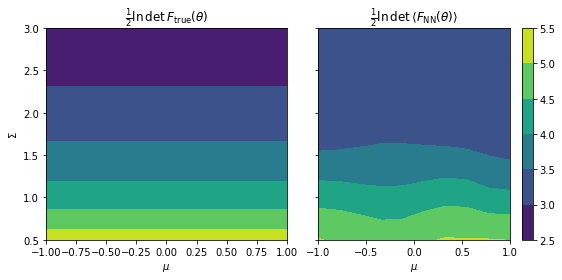

In [161]:
fig, axs = plt.subplots(nrows=1, ncols=2, figsize=(8,4), sharex="col", sharey=True)
(ax1, ax2) = axs

levels = [2.5, 3.0, 3.5, 4.0, 4.5, 5.0, 5.5]

dets1 =  jax.vmap(jnp.linalg.det)(jnp.array(fishers)).reshape(xs.shape)

ax1.contourf(xs, ys, 0.5*np.log(dets1), cmap='viridis', levels=levels)

dets2 = jax.vmap(jnp.linalg.det)(jnp.array(fishers_pred)).reshape(xs.shape) 

cs2 = ax2.contourf(xs, ys, 0.5*np.log(dets2), cmap='viridis', levels=levels)

plt.colorbar(cs2)

ax1.set_title(r'$ \frac{1}{2} \ln \det F_{\rm true}(\theta)$')

ax1.set_ylabel('$\Sigma$')
ax1.set_xlabel('$\mu$')

ax2.set_xlabel('$\mu$')
ax2.set_title(r'$ \frac{1}{2} \ln \det \langle F_{\rm NN}(\theta) \rangle $')
plt.tight_layout()

#plt.savefig("/Users/lucas/Documents/Documents - MacBook Pro di Admin/imperial/fishnets/info-comparison.png", dpi=400)

No artists with labels found to put in legend.  Note that artists whose label start with an underscore are ignored when legend() is called with no argument.


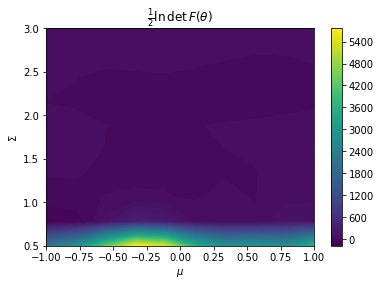

In [132]:
_data = jax.vmap(jnp.linalg.det)(jnp.array(fishers_pred) - jnp.array(fishers)).reshape(xs.shape)


im = plt.contourf(xs, ys, (_data), cmap='viridis', levels=100)
plt.colorbar(im)
#plt.yscale('log')
plt.ylabel('$\Sigma$')
plt.xlabel('$\mu$')
plt.title(r'$ \frac{1}{2} \ln \det F(\theta)$')
plt.legend(framealpha=0., loc='lower left')
plt.show()

In [421]:
fishers[200]

Array([[9.830508, 0.      ],
       [0.      , 4.831945]], dtype=float32)